# HW4 Gaussian Process
- Author: Yuege Xie (EID:yx4256)
- Python version: Python 3
- CS 391L Machine Learning HW4

In [1]:
# import packages
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import math
from os import listdir
np.random.seed(1023)
# check the python version
from platform import python_version
print("Current python version is {}".format(python_version()))
%matplotlib inline
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

Current python version is 3.6.9


In [2]:
def get_data(path, index):
    
    data_dict = {}
    
    for i in range(1, 6):
        
        # get data table
        cur_path = path.format(i)
        file = cur_path + [x for x in listdir(cur_path) if 'csv'==x[-3:]][0]
        print("Processing {} ...".format(file))
        data = pd.read_csv(file)
        
        # filter data with index_c>= 0
        geq0 = data['{}_c'.format(index[:-2])] >= 0
        data = data[geq0]
        
        # add data to the ditionary
        ind = 'rep{}'.format(i)
        data_dict[ind] = {'frame': np.array(data['frame']), 
                          'elpt': np.array(data['elapsed_time']),
                          'val': np.array(data[index])}
        
    return data_dict

In [3]:
def sample_data(data_dict, start, end):
    
    ind = np.random.randint(1, 6, end-start)
    sdata = {'frame': np.zeros(end-start), 'elpt': np.zeros(end-start),
            'val': np.zeros(end-start)}
    
    for i in range(end-start):
        sdata['frame'][i] = data_dict['rep{}'.format(ind[i])]['frame'][start+i]
        sdata['elpt'][i] = data_dict['rep{}'.format(ind[i])]['elpt'][start+i]
        sdata['val'][i] = data_dict['rep{}'.format(ind[i])]['val'][start+i]
    
    return sdata

In [4]:
def plot_pred(x, y, x_plot, y_gpr, y_std, gpr, index, kernel, filename):
    plt.figure(figsize=(10,6))
    plt.fill_between(x_plot[:,0], y_gpr - 1.96*y_std, y_gpr + 1.96*y_std, color='grey',
                 alpha=0.2, label='95% confidence interval')
    plt.plot(x_plot[:,0], y_gpr, color='k', label='predictions')
    plt.plot(x, y, 'g.', markersize=3, label='Observations')
    plt.xlabel('frame')
    plt.ylabel('CT: '+index)
    if 'Local' in filename:
        plt.title('Mean Predictions of Local Kernels')
    elif 'Posterior' in filename:
        plt.title("Posterior (kernel: %s)\n Log-Likelihood: %.3f"
              % (gpr.kernel_, gpr.log_marginal_likelihood(gpr.kernel_.theta)),
              fontsize=12)
    else:
        plt.title("Prior (kernel:  %s)" % kernel, fontsize=12)
    
    plt.legend(loc=0)
    plt.savefig('./{}.pdf'.format(filename))
    plt.show()

In [5]:
# get and preprocess data from chosen path and index
path = "./data_GP/CT/block{}-UNWEIGHTED-SLOW-NONDOMINANT-RANDOM/"
index = '15_x'
data = get_data(path, index)

Processing ./data_GP/CT/block1-UNWEIGHTED-SLOW-NONDOMINANT-RANDOM/20161223113053-59968-right-speed_0.500.csv ...
Processing ./data_GP/CT/block2-UNWEIGHTED-SLOW-NONDOMINANT-RANDOM/20161223113517-59968-right-speed_0.500.csv ...
Processing ./data_GP/CT/block3-UNWEIGHTED-SLOW-NONDOMINANT-RANDOM/20161223114616-59968-right-speed_0.500.csv ...
Processing ./data_GP/CT/block4-UNWEIGHTED-SLOW-NONDOMINANT-RANDOM/20161223115220-59968-right-speed_0.500.csv ...
Processing ./data_GP/CT/block5-UNWEIGHTED-SLOW-NONDOMINANT-RANDOM/20161223115454-59968-right-speed_0.500.csv ...


In [6]:
# initialization
total_len = min([len(data['rep{}'.format(i)]['val']) for i in range(1,6)])
sdata = sample_data(data, 0, total_len)
dup = 1
x_plot = np.linspace(0, total_len, total_len*dup).reshape(-1,1)
x = sdata['frame'].reshape(-1,1)
y = sdata['val']

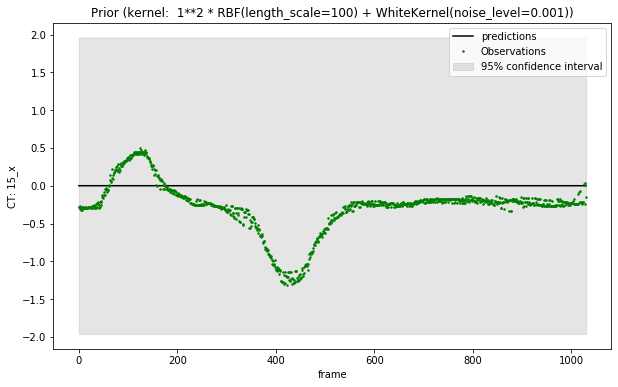

In [7]:
# get prior
kernel = 1*RBF(100) + WhiteKernel(1e-3)
gpr = GaussianProcessRegressor(kernel=kernel)
y_gpr, y_std = gpr.predict(x_plot, return_std=True)
plot_pred(x, y, x_plot, y_gpr, y_std, gpr, index, kernel, 'Global-Prior')

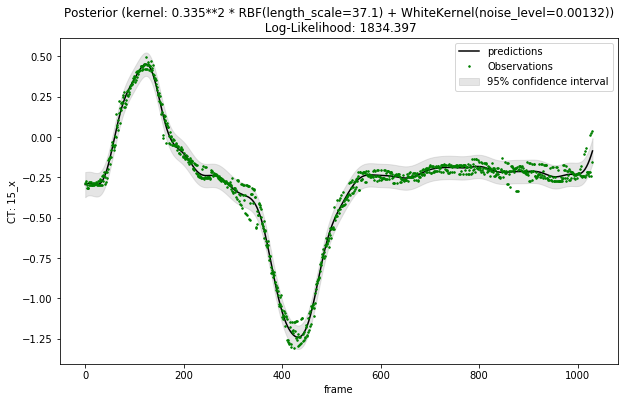

In [8]:
# plot global posterior
gpr.fit(x, y)
y_gpr, y_std = gpr.predict(x_plot, return_std=True)
plot_pred(x, y, x_plot, y_gpr, y_std, gpr, index, kernel, 'Global-Posterior')

In [9]:
# local kernels
inter, delta = 100, 10
gpr = GaussianProcessRegressor(kernel=kernel)
theta0 = gpr.kernel.theta
y_plot = np.zeros(total_len*dup)
std_plot = np.zeros(total_len*dup)
param_dict = {'sigma_f':[], 'sigma_l':[], 'sigma_n':[]}

for i in range(0, total_len-inter+1, delta):

    x_local = sdata['frame'][i:i+inter].reshape(-1,1)
    y_local = sdata['val'][i:i+inter]
    
    gpr = GaussianProcessRegressor(kernel=kernel)
    gpr.fit(x_local, y_local)
    
    tmpx = x_plot[i*dup: (i+inter)*dup]
    y_gpr_tmp, y_std_tmp = gpr.predict(tmpx, return_std=True)
    y_plot[i*dup: (i+inter)*dup] += y_gpr_tmp
    std_plot[i*dup: (i+inter)*dup] += y_std_tmp
    
    params = gpr.kernel_.theta
    param_dict['sigma_f'].append(params[0])
    param_dict['sigma_l'].append(params[1])
    param_dict['sigma_n'].append(params[2])

q = int(inter/delta)
count = np.ones(int(total_len/delta))*q
count[0:q-1], count[-q+1:] = range(1, q), range(q-1, 0, -1)
count = np.repeat(count, dup*delta)
y_plot, std_plot = y_plot/count, std_plot/count

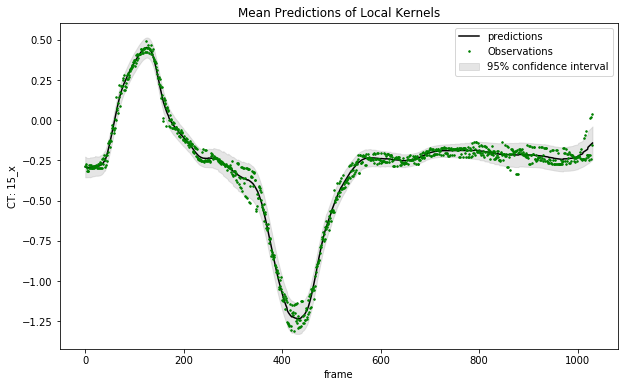

In [10]:
# plot local posterior
plot_pred(x, y, x_plot, y_plot, std_plot, gpr, index, kernel, 'Local')

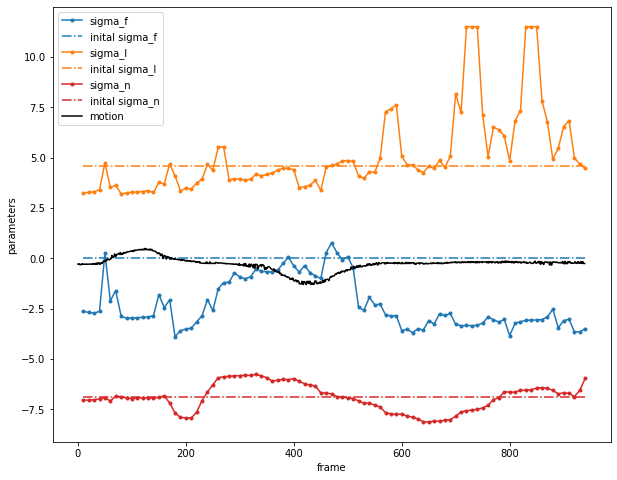

In [11]:
# plot parameters
plt.figure(figsize=(10,8))
xaxis = np.array(range(0, total_len-inter+1, delta)) + delta
one = np.ones(len(xaxis))
col = ['tab:blue', 'tab:orange', 'tab:red']
for i, item in enumerate(param_dict):
    plt.plot(xaxis, param_dict[item], c=col[i], marker='.', label=item)
    plt.plot(xaxis, one*theta0[i], c=col[i], linestyle='-.', label='inital '+item)
plt.plot(y[:xaxis[-1]], 'k', label='motion' )
plt.legend(loc=2)
plt.xlabel('frame')
plt.ylabel('parameters')
plt.savefig('parameters.pdf')
plt.show()

In [12]:
# print for latex table
print('interval & $\sigma_f$ & $\sigma_l$ & $\sigma_n$ &  & interval & $\sigma_f$ & $\sigma_l$ & $\sigma_n$ \\\\')
half = len(param_dict['sigma_f'])//2
for i in range(half):
    print('$[{}, {})$ & {:.2f} & {:.2f} & {:.2f}'.format(i*delta, 
            i*delta+inter, param_dict['sigma_f'][i], 
            param_dict['sigma_l'][i], param_dict['sigma_n'][i]), end=' & & ')
    print('$[{}, {})$ & {:.2f} & {:.2f} & {:.2f} \\\\'.format((i+half)*delta, 
            (i+half)*delta+inter, param_dict['sigma_f'][i+half], 
            param_dict['sigma_l'][i+half], param_dict['sigma_n'][i+half]) )

interval & $\sigma_f$ & $\sigma_l$ & $\sigma_n$ &  & interval & $\sigma_f$ & $\sigma_l$ & $\sigma_n$ \\
$[0, 100)$ & -2.64 & 3.25 & -7.05 & & $[470, 570)$ & 0.28 & 4.69 & -6.87 \\
$[10, 110)$ & -2.68 & 3.28 & -7.04 & & $[480, 580)$ & -0.08 & 4.85 & -6.89 \\
$[20, 120)$ & -2.73 & 3.31 & -7.03 & & $[490, 590)$ & 0.08 & 4.86 & -6.93 \\
$[30, 130)$ & -2.63 & 3.41 & -6.98 & & $[500, 600)$ & -0.47 & 4.82 & -6.97 \\
$[40, 140)$ & 0.27 & 4.74 & -6.93 & & $[510, 610)$ & -2.43 & 4.08 & -7.08 \\
$[50, 150)$ & -2.11 & 3.53 & -7.09 & & $[520, 620)$ & -2.59 & 3.98 & -7.20 \\
$[60, 160)$ & -1.60 & 3.63 & -6.86 & & $[530, 630)$ & -1.93 & 4.31 & -7.20 \\
$[70, 170)$ & -2.87 & 3.20 & -6.87 & & $[540, 640)$ & -2.31 & 4.28 & -7.29 \\
$[80, 180)$ & -2.98 & 3.25 & -6.93 & & $[550, 650)$ & -2.28 & 4.97 & -7.38 \\
$[90, 190)$ & -2.97 & 3.29 & -6.97 & & $[560, 660)$ & -2.81 & 7.29 & -7.67 \\
$[100, 200)$ & -2.95 & 3.30 & -6.93 & & $[570, 670)$ & -2.86 & 7.43 & -7.73 \\
$[110, 210)$ & -2.93 & 3.32 & -6.94 & & $